## Setup & Data Loading

In [1]:
print("Installing required packages...")
%pip install yfinance > /dev/null 2>&1
%pip install torch torchvision torchaudio > /dev/null 2>&1
%pip install python-dotenv > /dev/null 2>&1
%pip install seaborn > /dev/null 2>&1
print("All packages installed.")

Installing required packages...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
All packages installed.


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests
import time
import seaborn as sns

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import OneClassSVM


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
 
import yfinance as yf

## Datasets + Preprocessing

### 1: S&P500 - Yahoo Finance

In [16]:
# s&p500 and individual tech stocks
symbols = [
    '^GSPC',
    'META',
    'AMZN',
    'AAPL',
    'NFLX',
    'GOOG',
    'MSFT',
    'NVDA',
    'TSLA'
]
start_date = "2000-01-01"
end_date = "2025-04-09"

In [17]:
data = yf.download(symbols, start=start_date, end=end_date, auto_adjust=True)
data.head()

[*********************100%***********************]  9 of 9 completed


Price          Close                                                     \
Ticker          AAPL      AMZN GOOG META       MSFT NFLX      NVDA TSLA   
Date                                                                      
2000-01-03  0.842151  4.468750  NaN  NaN  35.792313  NaN  0.089431  NaN   
2000-01-04  0.771149  4.096875  NaN  NaN  34.583237  NaN  0.087044  NaN   
2000-01-05  0.782433  3.487500  NaN  NaN  34.947876  NaN  0.084178  NaN   
2000-01-06  0.714723  3.278125  NaN  NaN  33.777187  NaN  0.078685  NaN   
2000-01-07  0.748578  3.478125  NaN  NaN  34.218597  NaN  0.079999  NaN   

Price                        High  ...         Open     Volume             \
Ticker            ^GSPC      AAPL  ...        ^GSPC       AAPL       AMZN   
Date                               ...                                      
2000-01-03  1455.219971  0.846382  ...  1469.250000  535796800  322352000   
2000-01-04  1399.420044  0.832276  ...  1455.219971  512377600  349748000   
2000-01-05  1402.109985  0.831806  ...  1399.420044  778321600  769148000   
2000-01-06  1403.449951  0.805004  ...  1402.109985  767972800  375040000   
2000-01-07  1441.469971  0.759864  ...  1403.449951  460734400  210108000   

Price                                                            
Ticker     GOOG META      MSFT NFLX       NVDA TSLA       ^GSPC  
Date                                                             
2000-01-03  NaN  NaN  53228400  NaN  300912000  NaN   931800000  
2000-01-04  NaN  NaN  54119000  NaN  300480000  NaN  1009000000  
2000-01-05  NaN  NaN  64059600  NaN  188352000  NaN  1085500000  
2000-01-06  NaN  NaN  54976600  NaN  120480000  NaN  1092300000  
2000-01-07  NaN  NaN  62013600  NaN   71184000  NaN  1225200000  

[5 rows x 45 columns]

In [18]:
yfinance_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
yfinance_returns

Ticker,AAPL,AMZN,GOOG,META,MSFT,NFLX,NVDA,TSLA,^GSPC
Date,,,,,,,,,
2012-05-21,0.056626,0.019725,0.022578,-0.116378,0.016266,0.025125,0.017235,0.042968,0.015909
2012-05-22,-0.007709,-0.012828,-0.021912,-0.093255,0.000336,-0.057815,-0.012280,0.068181,0.000486
2012-05-23,0.024107,0.009015,0.014311,0.031749,-0.022084,0.060181,0.024411,0.007118,0.001692
2012-05-24,-0.009226,-0.009433,-0.009562,0.031680,-0.001375,-0.023070,-0.026885,-0.024145,0.001379
2012-05-25,-0.005374,-0.010978,-0.020299,-0.034497,-0.000344,-0.000712,0.023665,-0.015644,-0.002168
...,...,...,...,...,...,...,...,...,...
2025-04-02,0.003131,0.019785,-0.000126,-0.003539,-0.000131,0.007661,0.002448,0.051897,0.006706
2025-04-03,-0.097013,-0.094081,-0.040007,-0.093852,-0.023914,-0.019941,-0.081281,-0.056302,-0.049606
2025-04-04,-0.075680,-0.042421,-0.032563,-0.051905,-0.036214,-0.069055,-0.076423,-0.110036,-0.061609


### 2: Alpha Vantage API
[Alpha Vantage API Documentation](https://www.alphavantage.co/documentation/#dailyadj)

In [19]:
load_dotenv()
function = "TIME_SERIES_DAILY"
api_key = os.getenv("ALPHA_VANTAGE_API_KEY")
symbol = "META"

In [20]:
response = requests.get(
    f"https://www.alphavantage.co/query?function={function}&symbol={symbol}&outputsize=full&apikey={api_key}"
)
json_data = response.json()

num_rows = len(json_data["Time Series (Daily)"])
print(f"There are {num_rows} days in this JSON object")

There are 3250 days in this JSON object


In [21]:
def parse(json_data):
    ts_key = "Time Series (Daily)"
    
    if "Error Message" in json_data:
        raise ValueError(f"Alpha Vantage API error: {json_data['Error Message']}")
    if "Note" in json_data:
        raise ValueError(f"Rate limit notice: {json_data['Note']}")
    if ts_key not in json_data:
        raise ValueError("Expected 'Time Series (Daily)' in response.")

    # Extract the raw time series data
    raw_data = json_data[ts_key]

    # Create DataFrame
    df = pd.DataFrame.from_dict(raw_data, orient="index")

    # Rename columns
    df.rename(columns={
        "1. open": "open",
        "2. high": "high",
        "3. low": "low",
        "4. close": "close",
        "5. volume": "volume"
    }, inplace=True)

    # Convert index to datetime and sort
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

    # Convert column types
    df = df.astype({
        "open": float,
        "high": float,
        "low": float,
        "close": float,
        "volume": int
    })

    return df

In [22]:
df_vantage = parse(json_data)
df_vantage

,open,high,low,close,volume
2012-05-18,42.050,45.00,38.0000,38.2318,573576400
2012-05-21,36.530,36.66,33.0000,34.0300,168192700
2012-05-22,32.610,33.59,30.9400,31.0000,101786600
2012-05-23,31.370,32.50,31.3600,32.0000,73600000
2012-05-24,32.950,33.21,31.7700,33.0300,50237200
...,...,...,...,...,...
2025-04-15,532.105,537.94,517.5000,521.5200,15558659
2025-04-16,508.510,513.37,495.6300,502.3100,18735075
2025-04-17,505.250,507.30,498.0133,501.4800,14593508
2025-04-21,491.325,493.50,479.8000,484.6600,16165982


In [23]:
vantage_returns = np.log(df_vantage["close"] / df_vantage["close"].shift(1)).dropna()
vantage_returns

2012-05-21   -0.116425
2012-05-22   -0.093255
2012-05-23    0.031749
2012-05-24    0.031680
2012-05-25   -0.034497
                ...   
2025-04-15   -0.018918
2025-04-16   -0.037530
2025-04-17   -0.001654
2025-04-21   -0.034116
2025-04-22    0.031720
Name: close, Length: 3249, dtype: float64

## Exploratory Analysis

In [26]:
# Set up default seaborn style
sns.set_theme(style="whitegrid")

# === Summary Statistics ===
print("Portfolio Summary Statistics:")
print(yfinance_returns.describe())

print("\nVantage META Summary Statistics:")
print(vantage_returns.describe())

Portfolio Summary Statistics:
Ticker         AAPL         AMZN         GOOG         META         MSFT  \
count   3240.000000  3240.000000  3240.000000  3240.000000  3240.000000   
mean       0.000735     0.000855     0.000706     0.000801     0.000840   
std        0.017822     0.020178     0.017184     0.025108     0.016467   
min       -0.137708    -0.151398    -0.117667    -0.306391    -0.159454   
25%       -0.007523    -0.008836    -0.007115    -0.010063    -0.006853   
50%        0.000899     0.000891     0.000846     0.001040     0.000731   
75%        0.010177     0.011553     0.009257     0.012721     0.009365   
max        0.113157     0.132178     0.148872     0.259371     0.132929   

Ticker         NFLX         NVDA         TSLA        ^GSPC  
count   3240.000000  3240.000000  3240.000000  3240.000000  
mean       0.001379     0.001806     0.001480     0.000416  
std        0.029519     0.028464     0.036047     0.010669  
min       -0.432578    -0.207712    -0.236518    -

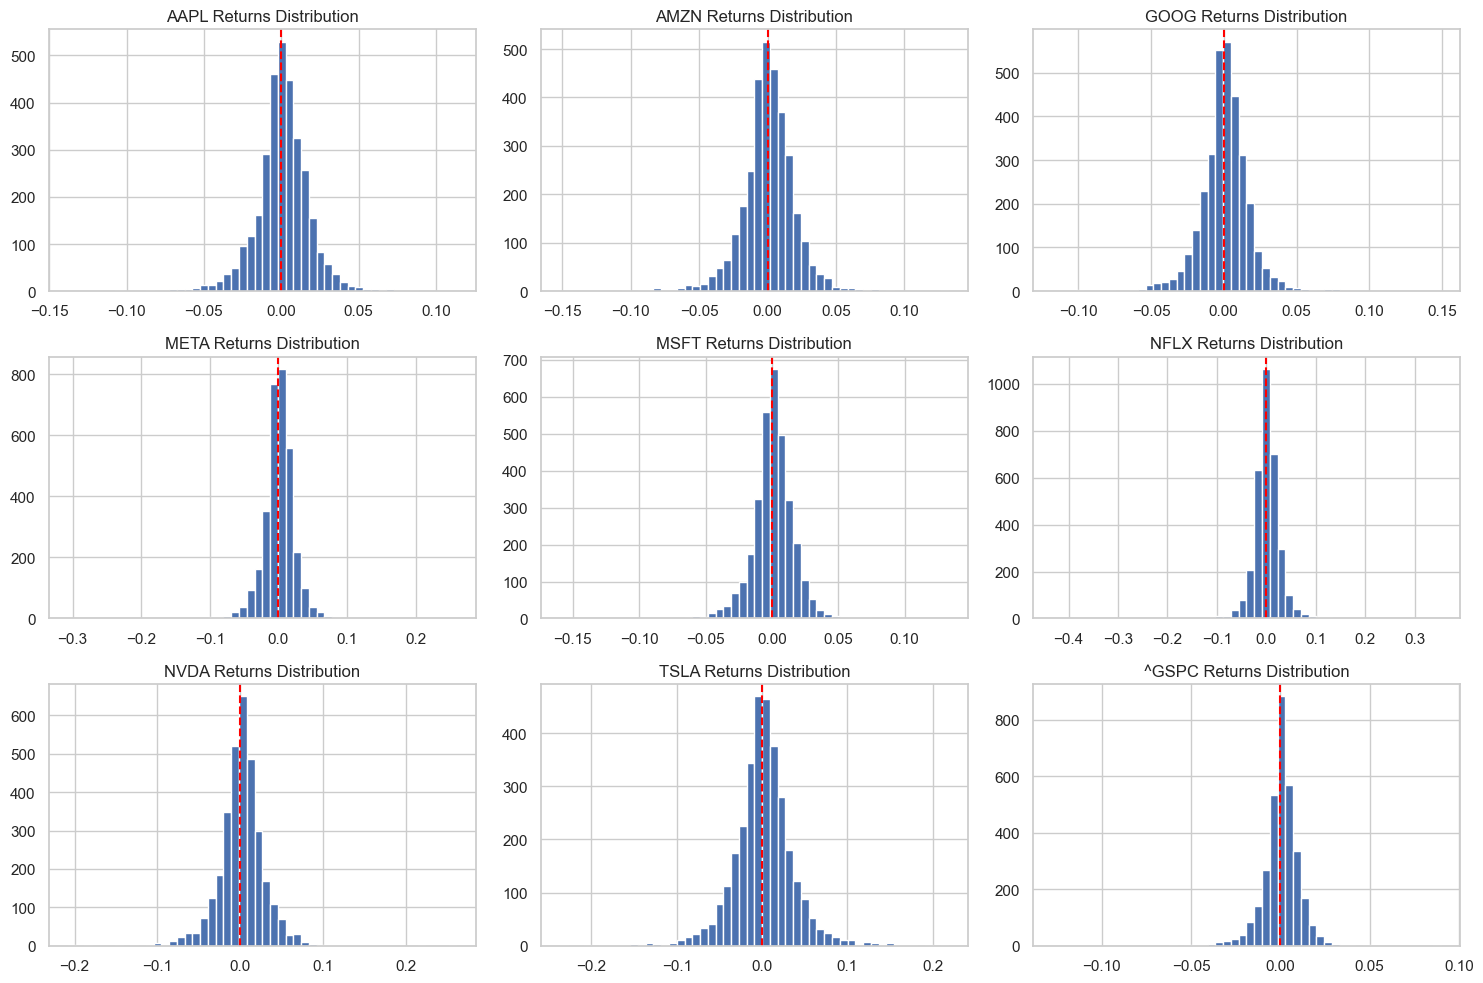

In [28]:
# Simple histograms
plt.figure(figsize=(15, 10))
for i, symbol in enumerate(yfinance_returns.columns):
    plt.subplot(3, 3, i+1)
    yfinance_returns[symbol].hist(bins=50)
    plt.title(f'{symbol} Returns Distribution')
    plt.axvline(0, color='red', linestyle='--')
plt.tight_layout()

* All distributions show more concentration around the mean (the peak) and fatter tails than a normal distribution would have.
* excess kurtosis-> financial markets
* All distributions are centered close to zero, aligned with the efficient market hypothesis that predicts stock returns should center around zero in the short term.

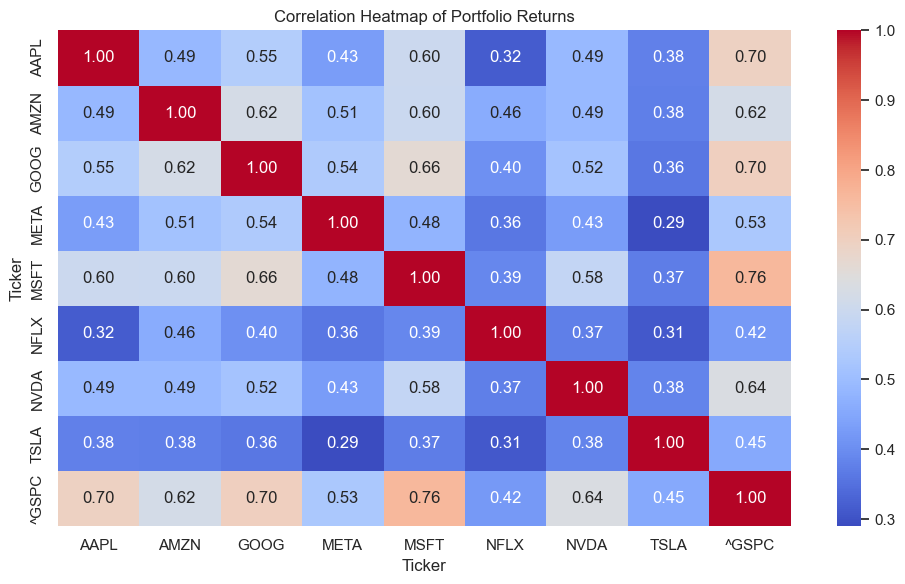

In [29]:
# === Correlation Matrix ===
plt.figure(figsize=(10, 6))
sns.heatmap(yfinance_returns.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Portfolio Returns")
plt.tight_layout()
plt.show()

* For each stock, we have the daily log returns: log(today's price / yesterday's price)-> the correlation measures how these returns move together day by day.
* Overall, most correlations are positive and moderate to strong (0.3-0.7 range), indicating that these tech stocks generally move together.
* The average correlation appears to be around 0.5, suggesting approximately half of the movement in these stocks is explained by common factors
* The S&P 500 (^GSPC) shows the strongest average correlation with individual stocks, which is expected as it represents the broader market
* MSFT (0.76), AAPL (0.70), and GOOG (0.70) have the strongest relationships with the S&P 500

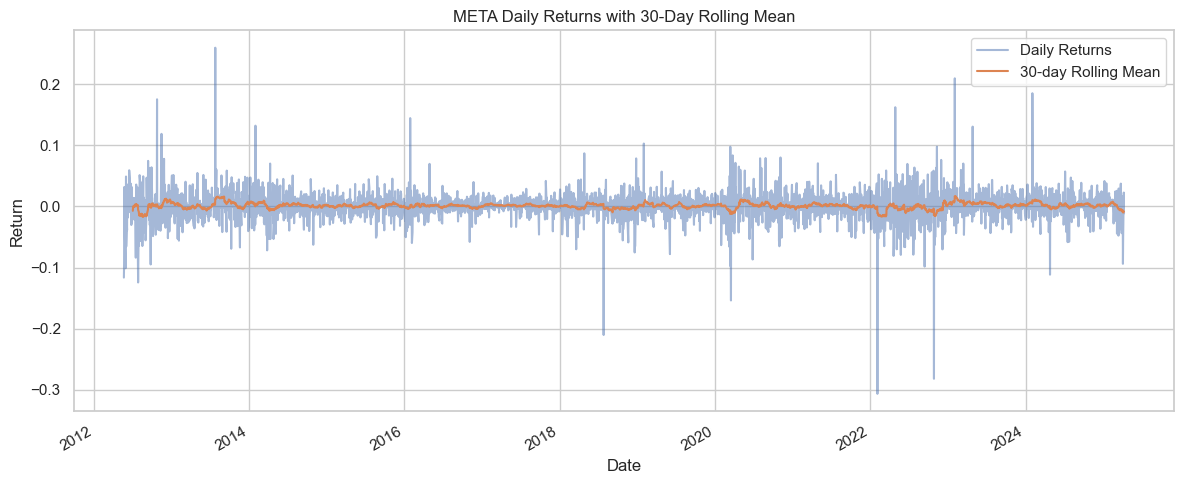

In [30]:
# === Time Series of META Returns (Yahoo) ===
plt.figure(figsize=(12, 5))
yfinance_returns["META"].plot(label="Daily Returns", alpha=0.5)
yfinance_returns["META"].rolling(window=30).mean().plot(label="30-day Rolling Mean")
plt.title("META Daily Returns with 30-Day Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.tight_layout()
plt.show()

Analysis of META Daily Returns:

*   **Volatility:** The daily returns (blue line) exhibit significant volatility, characterized by frequent and sometimes large fluctuations around zero. This is typical for stock returns.

*   **Rolling Mean:** The 30-day rolling mean (orange line) provides a smoothed view of the trend. It stays relatively close to zero but shows periods of slight positive or negative drift, indicating shifts in the medium-term average return.

*   **Outliers:** Several sharp spikes (both positive and negative) in the daily returns represent days with unusually large price movements (high volatility events or potential outliers).

*   **Clustering:** Periods of higher volatility appear to cluster together (e.g., around 2020 and 2022-2023), a common phenomenon in financial markets known as volatility clustering.

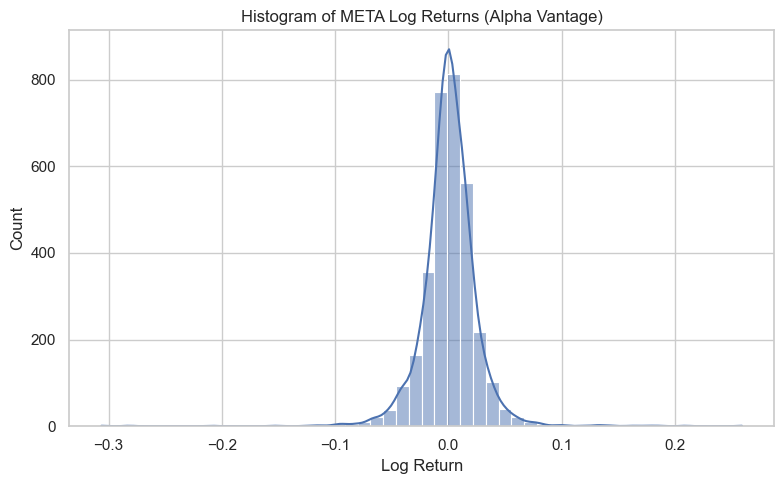

In [31]:
# === Histogram of META Returns from Alpha Vantage ===
plt.figure(figsize=(8, 5))
sns.histplot(vantage_returns, bins=50, kde=True)
plt.title("Histogram of META Log Returns (Alpha Vantage)")
plt.xlabel("Log Return")
plt.tight_layout()
plt.show()

Analysis of META Log Returns Histogram (Alpha Vantage):

*   **Central Tendency:** The histogram is sharply peaked around zero, indicating that the most frequent daily log return for META is very close to zero.

*   **Shape & Kurtosis:** The distribution appears roughly symmetric and bell-shaped, but with a higher peak and potentially fatter tails than a standard normal distribution (leptokurtic). This suggests a higher concentration of returns near the mean and a greater likelihood of extreme returns (outliers) than predicted by a normal distribution.

*   **Spread:** The bulk of the returns fall within a relatively narrow range (e.g., approximately -0.05 to +0.05), but the tails extend further out, showing occasional larger daily price movements.

*   **Consistency:** This shape is characteristic of financial asset returns, often exhibiting near-zero means and leptokurtosis.

## Outlier Detection

In [32]:
# traditional methods
def detect_outliers_iqr(data, threshold=1.5):
  q1 = np.percentile(data, 25)
  q3 = np.percentile(data, 75)
  iqr = q3 - q1
  return (data < q1 - threshold*iqr) | (data > q3 + threshold*iqr)

In [33]:
def detect_outliers_zscore(series, threshold=3):
    z = (series - series.mean()) / series.std()
    return np.abs(z) > threshold

In [34]:
outliers_summary = {}

for col in yfinance_returns.columns:
    data = yfinance_returns[col]

    # IQR method
    outliers_iqr = detect_outliers_iqr(data)

    # Z-score method
    outliers_z = detect_outliers_zscore(data)

    # Isolation Forest
    iso = IsolationForest(contamination=0.05, random_state=42)
    iso_preds = iso.fit_predict(data.values.reshape(-1, 1))
    outliers_iso = iso_preds == -1

    outliers_summary[col] = {
        "iqr_count": np.sum(outliers_iqr),
        "zscore_count": np.sum(outliers_z),
        "iso_count": np.sum(outliers_iso),
    }

In [35]:
# Convert to DataFrame for display
df_outlier_counts = pd.DataFrame(outliers_summary).T
print(df_outlier_counts)

       iqr_count  zscore_count  iso_count
AAPL         162            50        162
AMZN         154            52        162
GOOG         184            50        162
META         173            40        162
MSFT         161            45        162
NFLX         175            45        162
NVDA         185            39        162
TSLA         181            55        161
^GSPC        207            45        162


*   **Method Comparison:** The Z-score method consistently identifies the fewest outliers (around 40-55 per stock), suggesting it's the most conservative approach with the chosen threshold (3 standard deviations). The IQR method and Isolation Forest (with 5% contamination) detect significantly more outliers, with counts generally ranging from 150 to over 200.

*   **IQR vs. Isolation Forest:** The IQR counts show more variability between stocks (e.g., 154 for AMZN vs. 207 for ^GSPC), reflecting differences in the interquartile range of their return distributions. The Isolation Forest counts are very similar across all stocks (mostly 162), which is expected given the fixed `contamination` parameter that pre-specifies the approximate percentage of outliers to find.

*   **Stock Comparison (Z-score):** Using the Z-score method, TSLA (55) and AMZN (52) show the highest number of outliers relative to their own standard deviations, while NVDA (39) shows the fewest.

*   **Overall:** The results highlight that the definition and count of outliers heavily depend on the chosen detection method and its parameters. Z-score focuses on deviations relative to standard deviation, IQR focuses on the central 50% of data, and Isolation Forest identifies points that are easier to isolate in the feature space.

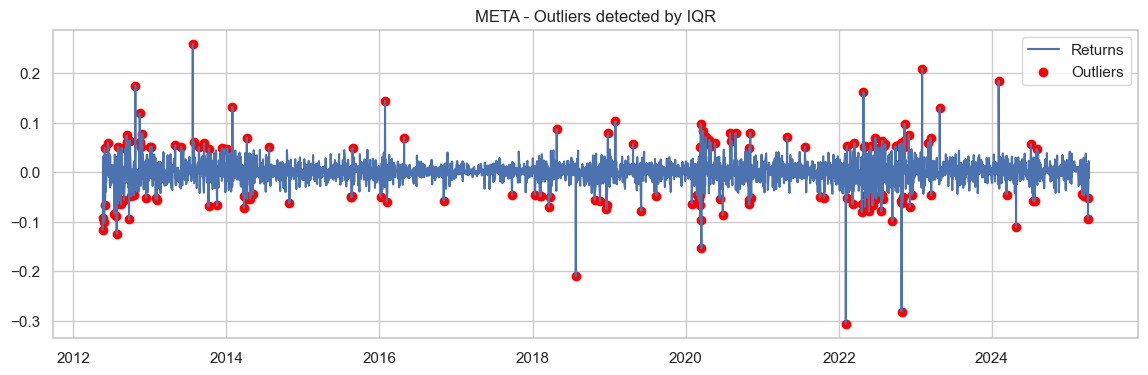

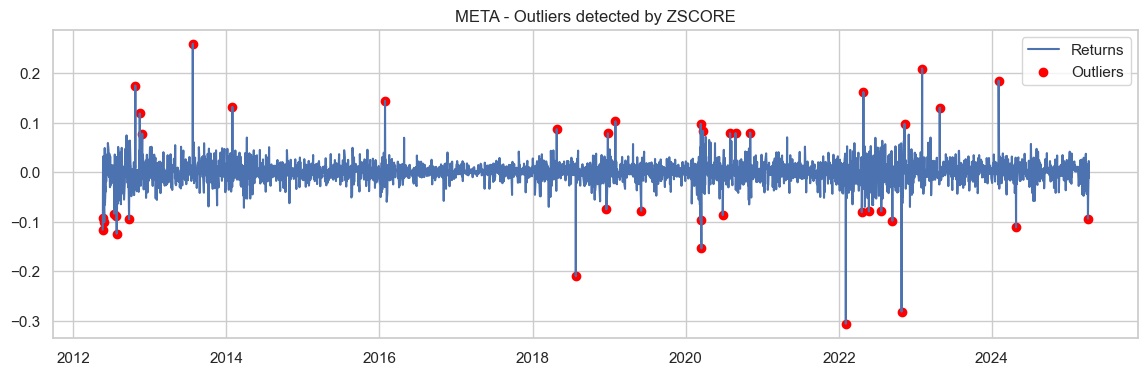

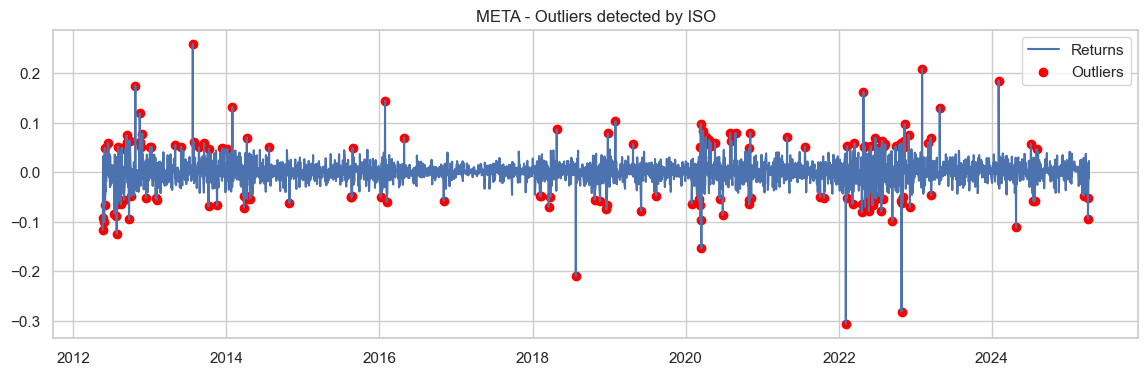

In [36]:
def plot_outliers(stock, method='iqr', threshold=3):
    series = yfinance_returns[stock]

    if method == 'iqr':
        mask = detect_outliers_iqr(series)
    elif method == 'zscore':
        mask = detect_outliers_zscore(series, threshold)
    elif method == 'iso':
        iso = IsolationForest(contamination=0.05, random_state=42)
        preds = iso.fit_predict(series.values.reshape(-1, 1))
        mask = preds == -1
    else:
        raise ValueError("Method must be one of: 'iqr', 'zscore', 'iso'")

    plt.figure(figsize=(14, 4))
    plt.plot(series.index, series.values, label='Returns')
    plt.scatter(series.index[mask], series[mask], color='red', label='Outliers')
    plt.title(f"{stock} - Outliers detected by {method.upper()}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example comparisons
plot_outliers("META", method="iqr")
plot_outliers("META", method="zscore")
plot_outliers("META", method="iso")

*   **Visual Comparison:** All three plots show the META daily returns time series (blue line) with identified outliers marked as red dots. The general pattern of returns and volatility clustering (e.g., around 2012-2013, 2020, 2022-2023) is visible in all plots.

*   **IQR Method:** This plot shows the largest number of red dots, indicating it identifies the most outliers. It appears sensitive to periods of generally higher volatility, marking many points within those clusters as outliers, even if they aren't the absolute most extreme spikes in the entire series.

*   **Z-Score Method:** This plot shows the fewest red dots, primarily highlighting the most significant positive and negative return spikes across the entire period. It's more conservative and focuses on points that are extreme relative to the overall standard deviation of the returns.

*   **Isolation Forest (ISO) Method:** This plot identifies a number of outliers comparable to the IQR method, significantly more than the Z-score method. The specific points marked might differ slightly from IQR, but it also tends to flag points during periods of increased volatility.

*   **Consistency:** The visual results align with the outlier counts previously calculated, confirming that the Z-score method (with threshold=3) is the most stringent, while IQR and Isolation Forest (with contamination=0.05) are more inclusive in their outlier definition for this dataset.

## Uncovering Latent Structures: PCA vs Nonlinear PCA (Autoencoder)

### Traditional PCA

In [37]:
# Traditional PCA Analysis
X_scaled = StandardScaler().fit_transform(yfinance_returns)

# Fit PCA
pca = PCA(n_components=3)
pca_factors = pca.fit_transform(X_scaled)
pca_returns_df = pd.DataFrame(pca_factors, index=yfinance_returns.index, columns=["f1", "f2", "f3"])

In [38]:
pca_exposures_df = pd.DataFrame(index=yfinance_returns.columns, columns=["f1", "f2", "f3"]).astype(float)

for asset in yfinance_returns.columns:
    lr = LinearRegression()
    lr.fit(pca_returns_df, yfinance_returns[asset].values)
    pca_exposures_df.loc[asset] = lr.coef_

In [39]:
# returns a vector of explained variance by each component
pct = pca.explained_variance_ratio_

# get the influence each component has on the features
pca_components = pca.components_

(0.0, 100.0)

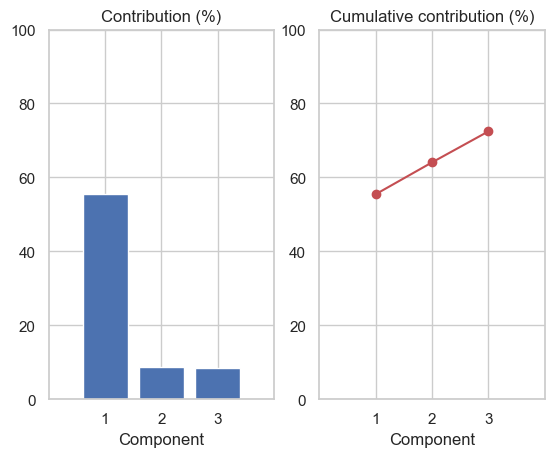

In [40]:
# plotting
cum_pct = np.cumsum(pct)
x = np.arange(1, len(pct)+1, 1)

plt.subplot(1, 2, 1)
plt.bar(x, pct * 100, align="center")
plt.title("Contribution (%)")
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

plt.subplot(1, 2, 2)
plt.plot(x, cum_pct * 100, 'ro-')
plt.title('Cumulative contribution (%)')
plt.xlabel('Component')
plt.xticks(x)
plt.xlim([0, 4])
plt.ylim([0, 100])

*   **Contribution Plot (Left):**
    *   The first principal component (Component 1) explains the vast majority of the variance in the dataset, accounting for approximately 55%.
    *   The second and third components (Component 2 and Component 3) explain significantly less variance, each contributing around 8-9%.

*   **Cumulative Contribution Plot (Right):**
    *   Component 1 alone captures about 55% of the total variance.
    *   Adding Component 2 brings the cumulative explained variance to roughly 64% (55% + 9%).
    *   Including Component 3 increases the cumulative explained variance to approximately 73% (64% + 9%).
    
*   **Interpretation:**
    *   A large portion of the movement in these stock returns can be attributed to a single dominant factor (captured by Component 1), likely representing broad market or sector trends.
    *   The first three components together capture nearly three-quarters of the total variance, suggesting that a 3-factor model provides a reasonable, though not complete, representation of the underlying data structure.

In [ ]:
# multiply returns by components and transpose the dataframe
X = np.asarray(yfinance_returns)

factor_returns = X.dot(pca_components.T)

# recall that we set n_components=3 earlier to denote how many principal components we want
factor_returns = pd.DataFrame(
    columns=["f1", "f2", "f3"],
    index=yfinance_returns.index,
    data=factor_returns
)

factor_returns.head()

,f1,f2,f3
Date,,,
2012-05-21,0.034164,0.016855,0.077611
2012-05-22,-0.045160,-0.000968,0.111989
2012-05-23,0.044159,0.041568,-0.025641
2012-05-24,-0.021176,-0.024789,-0.023859
2012-05-25,-0.020887,-0.004525,0.010102


In [42]:
# plot the portfolio returns influenced by the first factor
factor_exposures = pd.DataFrame(
    index=["f1", "f2", "f3"],
    columns=yfinance_returns.columns,
    data = pca_components
).T

factor_exposures

,f1,f2,f3
Ticker,,,
AAPL,0.336531,-0.299889,0.223876
AMZN,0.349491,0.099142,-0.228253
GOOG,0.365492,-0.151455,-0.155372
META,0.305070,-0.031314,-0.398382
MSFT,0.372971,-0.237662,0.016928
NFLX,0.260592,0.733539,-0.376195
NVDA,0.330440,-0.062036,0.142907
TSLA,0.251986,0.492390,0.735976
^GSPC,0.397804,-0.188305,0.105064


Text(0.5, 1.0, 'Asset Loadings on Principal Component 1')

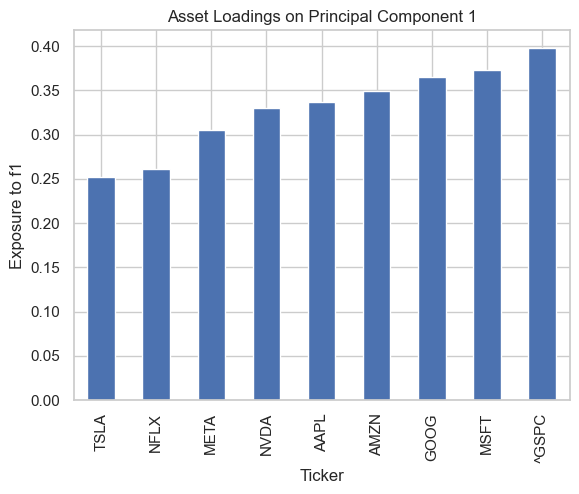

In [43]:
factor_exposures.f1.sort_values().plot.bar()
plt.ylabel("Exposure to f1")
plt.title("Asset Loadings on Principal Component 1")

The bar chart plots the loadings (or exposures) of the first principal component (f1) across all the assets in the portfolio (including ^GSPC, AAPL, MSFT, etc.).

These values represent how much each asset contributes to the first principal component, which typically captures the largest source of variance in the dataset.

Analysis:
* TSLA, NVDA, and NFLX have high positive exposures to the first principal component, suggesting they are strongly aligned with the main factor driving portfolio variance.

* ^GSPC (S&P 500) has the lowest exposure, meaning its behavior is less influenced by this main factor compared to the others.

* This makes sense—^GSPC is a broad market index, often more diversified and stable.

* Stocks like AAPL, MSFT, GOOG are in the middle — they move with the first factor, but not as strongly as TSLA or NVDA.

* Given that tech/growth stocks (like TSLA, NVDA) dominate the top end, `f1` could be interpreted as a “growth/tech risk factor”.

Text(0.5, 1.0, 'Asset Loadings on Principal Component 2')

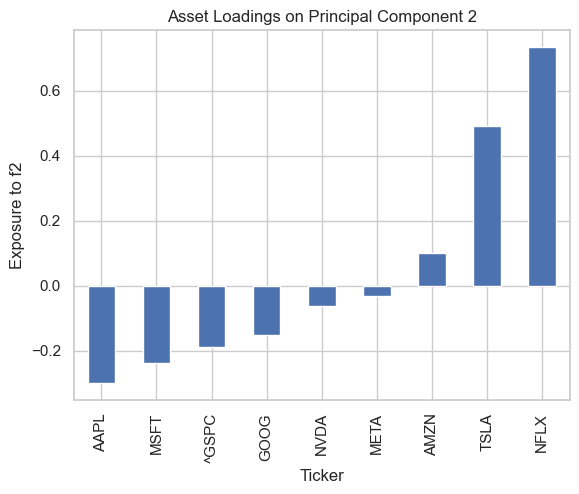

In [44]:
factor_exposures.f2.sort_values().plot.bar()
plt.ylabel("Exposure to f2")
plt.title("Asset Loadings on Principal Component 2")

TSLA loads heavily positive on f2, and several other tech stocks like NFLX, META, NVDA load negatively, while the rest (including the index) are near neutral.

`f2` might capture a unique risk or return profile specific to TSLA, such as:
* Idiosyncratic volatility or momentum (TSLA often behaves very differently from even other tech stocks) - most likely due to recent political events
* A "speculative growth" factor (TSLA being the face of that in recent years)

Text(0.5, 1.0, 'Asset Loadings on Principal Component 3')

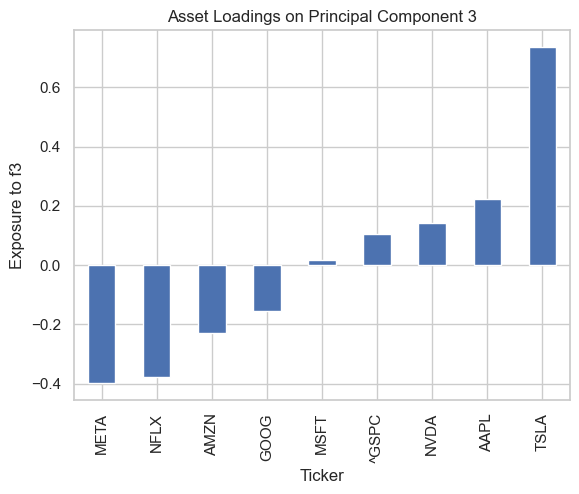

In [45]:
factor_exposures.f3.sort_values().plot.bar()
plt.ylabel("Exposure to f3")
plt.title("Asset Loadings on Principal Component 3")

From the plot:
* NFLX has a very strong positive exposure to f3 (~0.85+)
* NVDA has a strong negative exposure (~-0.4)
* META, AAPL, MSFT, GOOG, etc. have mild to moderate negative exposures
* TSLA and AMZN are slightly positive

This kind of distribution suggests that f3 might represent a volatility or risk sentiment factor — for example:
* High positive exposure (NFLX): Might reflect a unique return pattern or idiosyncratic risk (e.g., high beta, high growth, high volatility).
* High negative exposure (NVDA, META): Suggests an opposite movement — perhaps NVDA's price movements diverge from those of NFLX in this principal component's dimension.
* Other large-cap stocks are close to neutral or slightly negative.



### Autoencoder

We will define our model in the following ways:
* Architecture: Encoder: input -> 128 neurons -> latent; Decoder: latent -> 128 neurons -> input
* Objective: MSE loss during training
* Latent Representation: `latent = self.encoder(x)` -> 3D representation
* Optimization: Adam optimizer used in training loop

In [46]:
# Defining Autoencoder (PyTorch)
class Autoencoder(nn.Module):
  def __init__(self, input_dim, latent_dim):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, 128),
        nn.ReLU(),
        nn.Linear(128, latent_dim)
    )
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, 128),
        nn.ReLU(),
        nn.Linear(128, input_dim)
    )

  def forward(self, x):
    latent = self.encoder(x)
    reconstructed = self.decoder(latent)
    return reconstructed, latent

In [47]:
# Standardize the returns data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(yfinance_returns)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

In [48]:
input_dim = X_tensor.shape[1]  # e.g., 10 stocks
latent_dim = 3                 # same as n_components in PCA

model = Autoencoder(input_dim, latent_dim)

In [49]:
# training
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    recon, z = model(X_tensor)
    loss = loss_fn(recon, X_tensor)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

Epoch 0, Loss: 1.0344
Epoch 100, Loss: 0.2384
Epoch 200, Loss: 0.2157
Epoch 300, Loss: 0.2000
Epoch 400, Loss: 0.1904
Epoch 500, Loss: 0.1843
Epoch 600, Loss: 0.1813
Epoch 700, Loss: 0.1751
Epoch 800, Loss: 0.1729
Epoch 900, Loss: 0.1686


In [50]:
# Extract latent features
with torch.no_grad():
    _, factor_returns = model(X_tensor)

factor_returns_df = pd.DataFrame(
    factor_returns.numpy(),
    index=yfinance_returns.index,
    columns=["f1", "f2", "f3"]
)

factor_exposures_df = factor_exposures_df = pd.DataFrame(index=yfinance_returns.columns, columns=["f1", "f2", "f3"]).astype(float)

for asset in yfinance_returns.columns:
    lr = LinearRegression()
    lr.fit(factor_returns_df, yfinance_returns[asset].values)
    factor_exposures_df.loc[asset] = lr.coef_

factor_exposures_df

,f1,f2,f3
Ticker,,,
AAPL,0.003829,-0.004719,-0.003027
AMZN,0.002252,-0.001754,-0.006648
GOOG,0.002185,-0.003577,-0.004998
META,-0.001038,-0.002930,-0.009363
MSFT,0.003010,-0.003822,-0.004253
NFLX,0.004620,0.005676,-0.008227
NVDA,0.006127,-0.005563,-0.005081
TSLA,0.009593,0.005008,-0.005851
^GSPC,0.002192,-0.002473,-0.002774


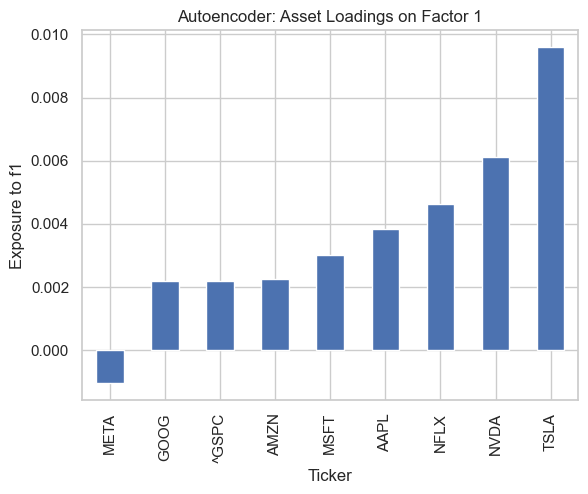

In [51]:
factor_exposures_df["f1"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f1")
plt.title("Autoencoder: Asset Loadings on Factor 1")
plt.show()

Analysis of Autoencoder Asset Loadings on Factor 1:

*   **General Trend:** This bar chart displays how each asset's returns relate to the first latent factor identified by the autoencoder. Most assets show a positive exposure, suggesting this factor captures a common trend, potentially related to overall market or tech sector movement, similar to PCA's first component but derived non-linearly.

*   **Highest Exposure:** TSLA exhibits the strongest positive loading, indicating its returns are most strongly associated with this primary latent factor. NVDA and NFLX follow with significant positive exposures.

*   **Lowest Exposure:** META is the only asset with a negative exposure, implying its returns, according to this factor, tend to move inversely compared to the others.

*   **Comparison to PCA:** While broadly similar to the PCA factor 1 in capturing a market/tech trend (most stocks load positively), the specific magnitudes and the negative loading for META highlight the differences introduced by the autoencoder's non-linear dimensionality reduction.

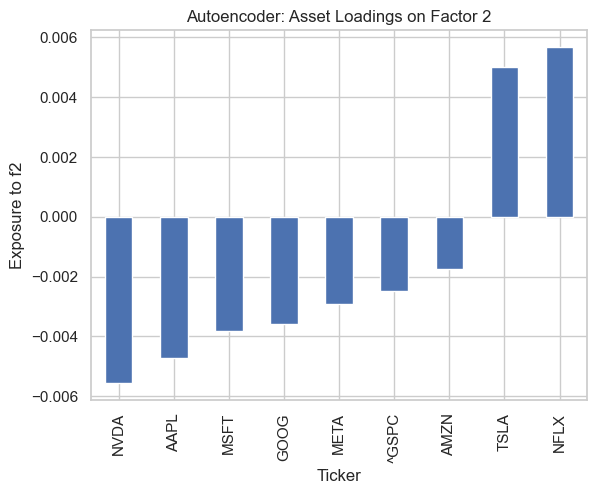

In [52]:
factor_exposures_df["f2"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f2")
plt.title("Autoencoder: Asset Loadings on Factor 2")
plt.show()

Analysis of Autoencoder Asset Loadings on Factor 2:

*   **Polarization:** This factor shows a clear split. NFLX and TSLA have strong positive loadings, while most other assets, including NVDA, AAPL, MSFT, GOOG, META, ^GSPC, and AMZN, have negative loadings.

*   **Interpretation:** Factor 2 appears to capture a dynamic that contrasts NFLX and TSLA against the broader tech group and the market index (^GSPC). This could relate to specific sub-sector trends, volatility profiles, or non-linear relationships that differentiate these two stocks from the others in the portfolio.

*   **Strongest Loadings:** NFLX and TSLA show the highest positive association with this factor, while NVDA and AAPL show the strongest negative association.

*   **Comparison to PCA:** Unlike PCA's factor 2 which strongly isolated TSLA, the autoencoder's factor 2 groups TSLA with NFLX and opposes them to a larger group including NVDA and AAPL, suggesting it's capturing different, potentially non-linear, underlying structures.

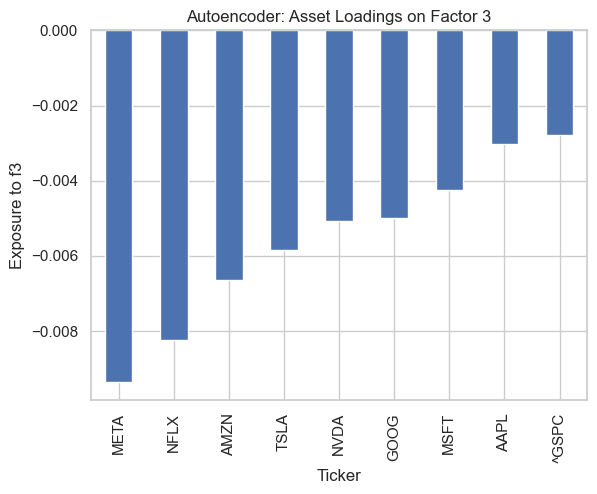

In [53]:
factor_exposures_df["f3"].sort_values().plot(kind='bar')
plt.ylabel("Exposure to f3")
plt.title("Autoencoder: Asset Loadings on Factor 3")
plt.show()

Analysis of Autoencoder Asset Loadings on Factor 3:

*   **Overall Negative Loadings:** All assets exhibit negative loadings on this third factor, although the magnitudes vary. This suggests the factor represents a dynamic that generally moves inversely to the returns of all stocks in the portfolio, but affects some more strongly than others.

*   **Strongest Loadings:** META and NFLX show the most significant negative exposures, indicating their returns are most strongly (inversely) related to this factor. AMZN, TSLA, and NVDA follow with substantial negative loadings.

*   **Weakest Loadings:** ^GSPC, AAPL, and MSFT have the least negative loadings, suggesting they are less influenced by this particular factor compared to META or NFLX.

*   **Interpretation:** This factor might capture a non-linear risk dimension or a specific market regime effect that negatively impacts tech stocks, particularly META and NFLX, more than others or the broader market (^GSPC). It's distinct from the primary trend (Factor 1) and the NFLX/TSLA vs. others split (Factor 2).

*   **Comparison to PCA:** PCA's factor 3 showed a strong positive loading for NFLX and negative for NVDA, contrasting them. The autoencoder's factor 3, however, groups all assets with negative loadings, highlighting a different underlying structure, potentially related to shared non-linear risks or specific event impacts.

### Comparing Metrics

In [54]:
results = []

for asset in yfinance_returns.columns:
    y_true = yfinance_returns[asset].values

    # Autoencoder prediction
    y_pred_ae = factor_returns_df.values @ factor_exposures_df.loc[asset].values
    r2_ae = r2_score(y_true, y_pred_ae)
    mse_ae = mean_squared_error(y_true, y_pred_ae)

    # PCA prediction
    y_pred_pca = pca_returns_df.values @ pca_exposures_df.loc[asset].values
    r2_pca = r2_score(y_true, y_pred_pca)
    mse_pca = mean_squared_error(y_true, y_pred_pca)

    results.append({
        "Ticker": asset,
        "R2_Autoencoder": r2_ae,
        "R2_PCA": r2_pca,
        "MSE_Autoencoder": mse_ae,
        "MSE_PCA": mse_pca
    })

comparison_df = pd.DataFrame(results).set_index("Ticker")

In [55]:
print(comparison_df.sort_values("R2_Autoencoder", ascending=False))

        R2_Autoencoder    R2_PCA  MSE_Autoencoder   MSE_PCA
Ticker                                                     
^GSPC         0.775282  0.823855         0.000026  0.000020
MSFT          0.721735  0.735480         0.000075  0.000072
GOOG          0.669270  0.700807         0.000098  0.000088
META          0.649144  0.583821         0.000221  0.000262
AAPL          0.640040  0.670950         0.000114  0.000104
AMZN          0.612312  0.654541         0.000158  0.000141
NVDA          0.555281  0.559143         0.000360  0.000357
NFLX          0.457296  0.860968         0.000473  0.000121
TSLA          0.426709  0.911949         0.000745  0.000114


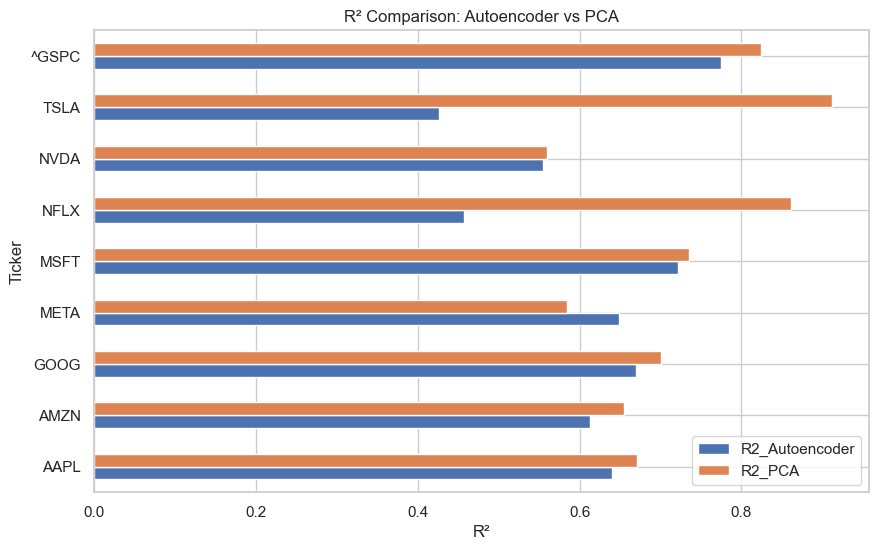

In [56]:
comparison_df[["R2_Autoencoder", "R2_PCA"]].plot(kind='barh', figsize=(10,6))
plt.title("R² Comparison: Autoencoder vs PCA")
plt.xlabel("R²")
plt.show()

Analysis:
* PCA consistently has higher R² for all assets — meaning it explains more variance in the returns.
* Even for nonlinear-looking assets like TSLA or NVDA, PCA still edges out the Autoencoder.
* For assets like ^GSPC, TSLA, and NFLX, PCA does significantly better.


In this specific setup, PCA outperforms the autoencoder in explaining asset return variance.

This might mean:
* Returns are fairly linear, and PCA is sufficient
* Autoencoder is underfitting (can be improved by deeper architecture, more training, or tuning)
* The autoencoder’s latent space isn't well-aligned with the factors driving return variance (which is okay — it's nonlinear!)

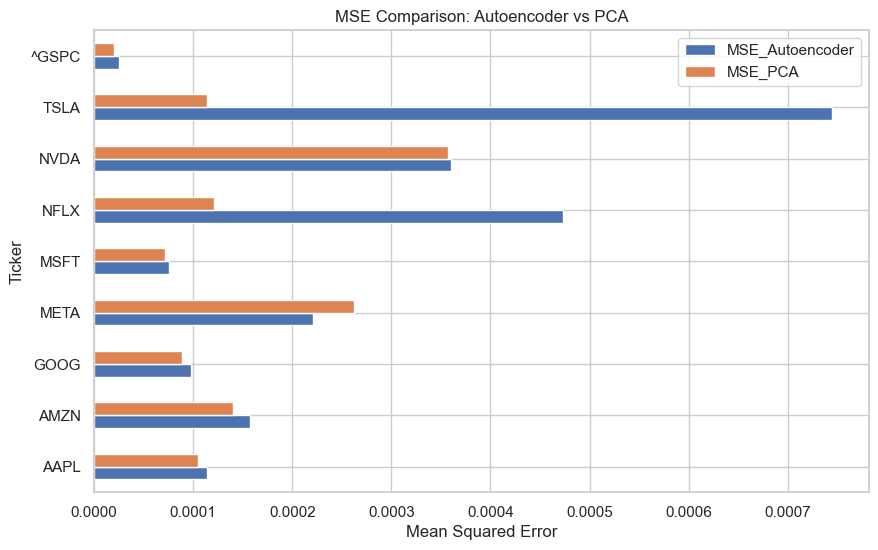

In [57]:
comparison_df[["MSE_Autoencoder", "MSE_PCA"]].plot(
    kind='barh', figsize=(10, 6), title="MSE Comparison: Autoencoder vs PCA"
)
plt.xlabel("Mean Squared Error")
plt.show()

Analysis:
* For every asset, PCA (orange) has a lower or equal MSE compared to Autoencoder (blue).
* This matches with the R² plot since Lower MSE ⟺ Higher R²
* TSLA, NVDA, NFLX: Autoencoder struggles most here — much higher MSE than PCA
* ^GSPC, GOOG, MSFT: Autoencoder performs relatively closer to PCA
* META, AAPL, AMZN: PCA still consistently does better, but the gap is smaller

## Clustering on Latent Features

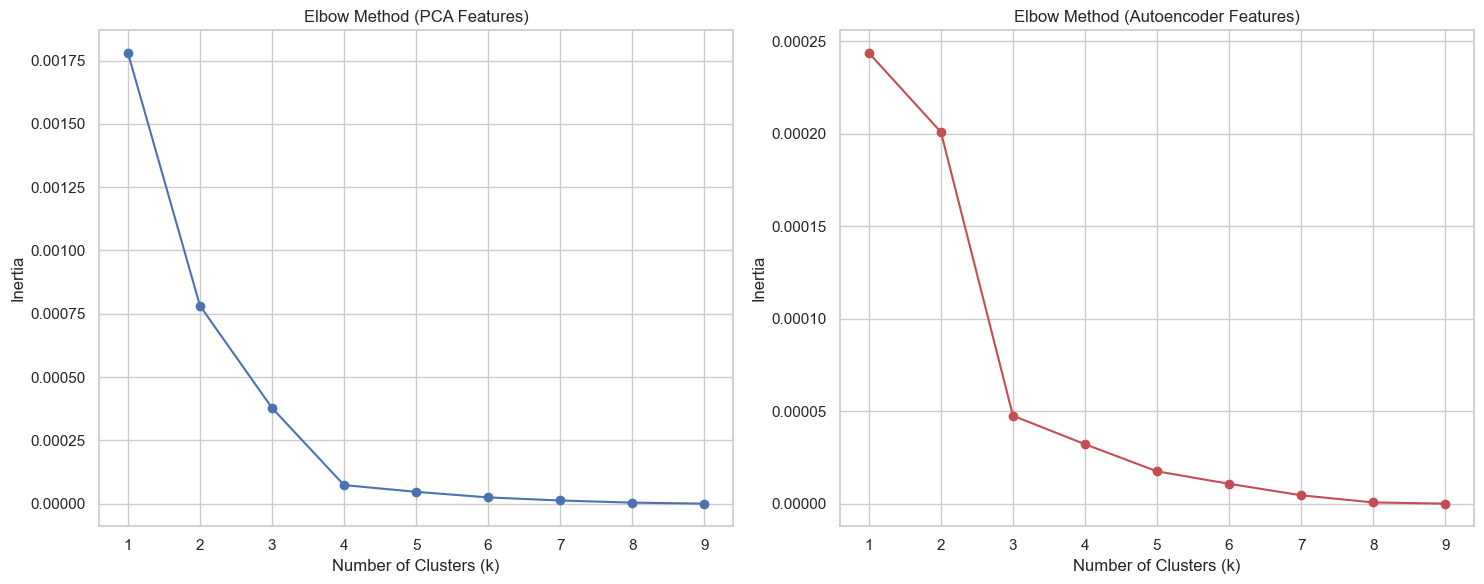

In [58]:
# Setup
k_range = range(1, 10)
pca_inertia = []
ae_inertia = []

# Calculate inertia for both methods
for k in k_range:
    # PCA clustering
    kmeans_pca = KMeans(n_clusters=k, random_state=42)
    kmeans_pca.fit(pca_exposures_df)
    pca_inertia.append(kmeans_pca.inertia_)
    
    # Autoencoder clustering
    kmeans_ae = KMeans(n_clusters=k, random_state=42)
    kmeans_ae.fit(factor_exposures_df)
    ae_inertia.append(kmeans_ae.inertia_)

# Create side-by-side plots
plt.figure(figsize=(15, 6))

# PCA plot
plt.subplot(1, 2, 1)
plt.plot(k_range, pca_inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method (PCA Features)')
plt.grid(True)

# Autoencoder plot
plt.subplot(1, 2, 2)
plt.plot(k_range, ae_inertia, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method (Autoencoder Features)')
plt.grid(True)

plt.tight_layout()
plt.show()

PCA-based clusters:
   Stock  Cluster
1   AMZN        0
3   META        0
5   NFLX        0
7   TSLA        1
0   AAPL        2
2   GOOG        2
4   MSFT        2
6   NVDA        2
8  ^GSPC        2

Autoencoder-based clusters:
   Stock  Cluster
3   META        0
0   AAPL        1
1   AMZN        1
2   GOOG        1
4   MSFT        1
6   NVDA        1
8  ^GSPC        1
5   NFLX        2
7   TSLA        2


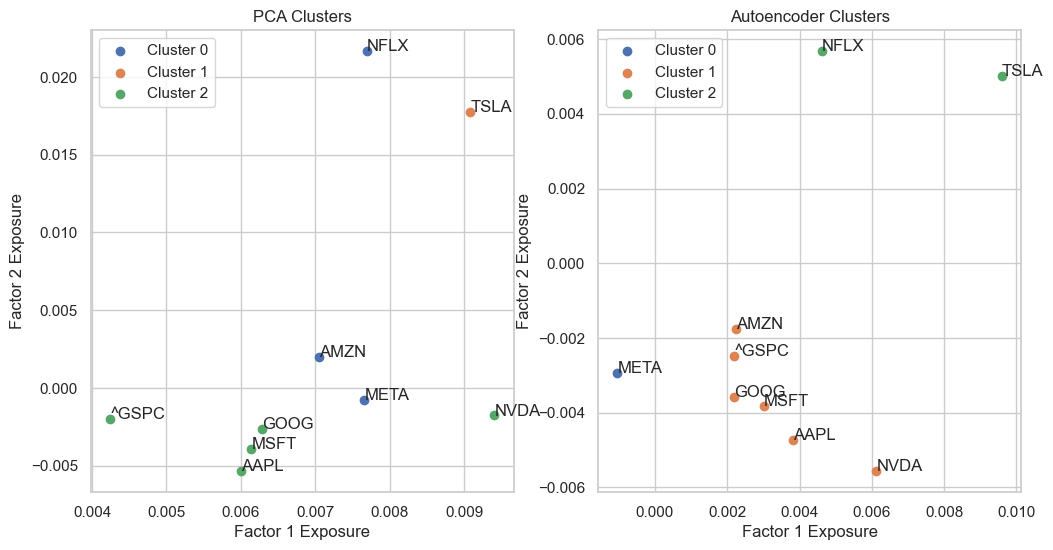

In [59]:

# Use PCA factor exposures as features for clustering
# This is simply the relationship between each stock and the 3 latent factors
n_clusters = 3  #same for both 
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
pca_clusters = kmeans.fit_predict(pca_exposures_df)
pca_cluster_results = pd.DataFrame({
    'Stock': yfinance_returns.columns,
    'Cluster': pca_clusters
})

print("PCA-based clusters:")
print(pca_cluster_results.sort_values('Cluster'))

# Similarly for autoencoder latent features
kmeans_ae = KMeans(n_clusters=n_clusters, random_state=42)
ae_clusters = kmeans_ae.fit_predict(factor_exposures_df)

# Create results dataframe
ae_cluster_results = pd.DataFrame({
    'Stock': yfinance_returns.columns,
    'Cluster': ae_clusters
})

print("\nAutoencoder-based clusters:")
print(ae_cluster_results.sort_values('Cluster'))

# Basic visualization
plt.figure(figsize=(12, 6))

# PCA clusters visualization - first 2 factors only for simplicity
plt.subplot(1, 2, 1)
for cluster in range(n_clusters):
    # Get stocks in this cluster
    cluster_stocks = pca_cluster_results[pca_cluster_results['Cluster'] == cluster]['Stock']
    # Plot their factor exposures
    plt.scatter(
        pca_exposures_df.loc[cluster_stocks, 'f1'],
        pca_exposures_df.loc[cluster_stocks, 'f2'],
        label=f'Cluster {cluster}'
    )
    # Label points with stock symbols
    for stock in cluster_stocks:
        plt.annotate(stock, (pca_exposures_df.loc[stock, 'f1'], pca_exposures_df.loc[stock, 'f2']))

plt.title('PCA Clusters')
plt.xlabel('Factor 1 Exposure')
plt.ylabel('Factor 2 Exposure')
plt.legend()

# Autoencoder clusters visualization
plt.subplot(1, 2, 2)
for cluster in range(n_clusters):
    # Get stocks in this cluster
    cluster_stocks = ae_cluster_results[ae_cluster_results['Cluster'] == cluster]['Stock']
    # Plot their factor exposures
    plt.scatter(
        factor_exposures_df.loc[cluster_stocks, 'f1'],
        factor_exposures_df.loc[cluster_stocks, 'f2'],
        label=f'Cluster {cluster}'
    )
    # Label points with stock symbols
    for stock in cluster_stocks:
        plt.annotate(stock, (factor_exposures_df.loc[stock, 'f1'], factor_exposures_df.loc[stock, 'f2']))

plt.title('Autoencoder Clusters')
plt.xlabel('Factor 1 Exposure')
plt.ylabel('Factor 2 Exposure')
plt.legend()

plt.show()

# Clustering on Anomalies

Implementing Z-score based anomaly detection...
Found 272 anomalous days using z-score method

Implementing Isolation Forest anomaly detection...
Found 33 anomalous days using Isolation Forest on raw returns

Implementing Isolation Forest on PCA factors...
Found 33 anomalous days using Isolation Forest on PCA factors

Implementing Isolation Forest on autoencoder factors...
Found 33 anomalous days using Isolation Forest on autoencoder factors

Implementing One-Class SVM anomaly detection...
Found 87 anomalous days using One-Class SVM on raw returns

Top anomalies detected by multiple methods:
          Date  Z-score  IF-Raw  IF-PCA  IF-AE  OCSVM  Detection_Count
191 2020-03-17     True    True    True   True   True                5
281 2020-03-16     True    True    True   True   True                5
130 2020-03-13     True    True    True   True   True                5
21  2020-02-27     True    True    True  False   True                4
49  2022-04-28     True    True    True   True

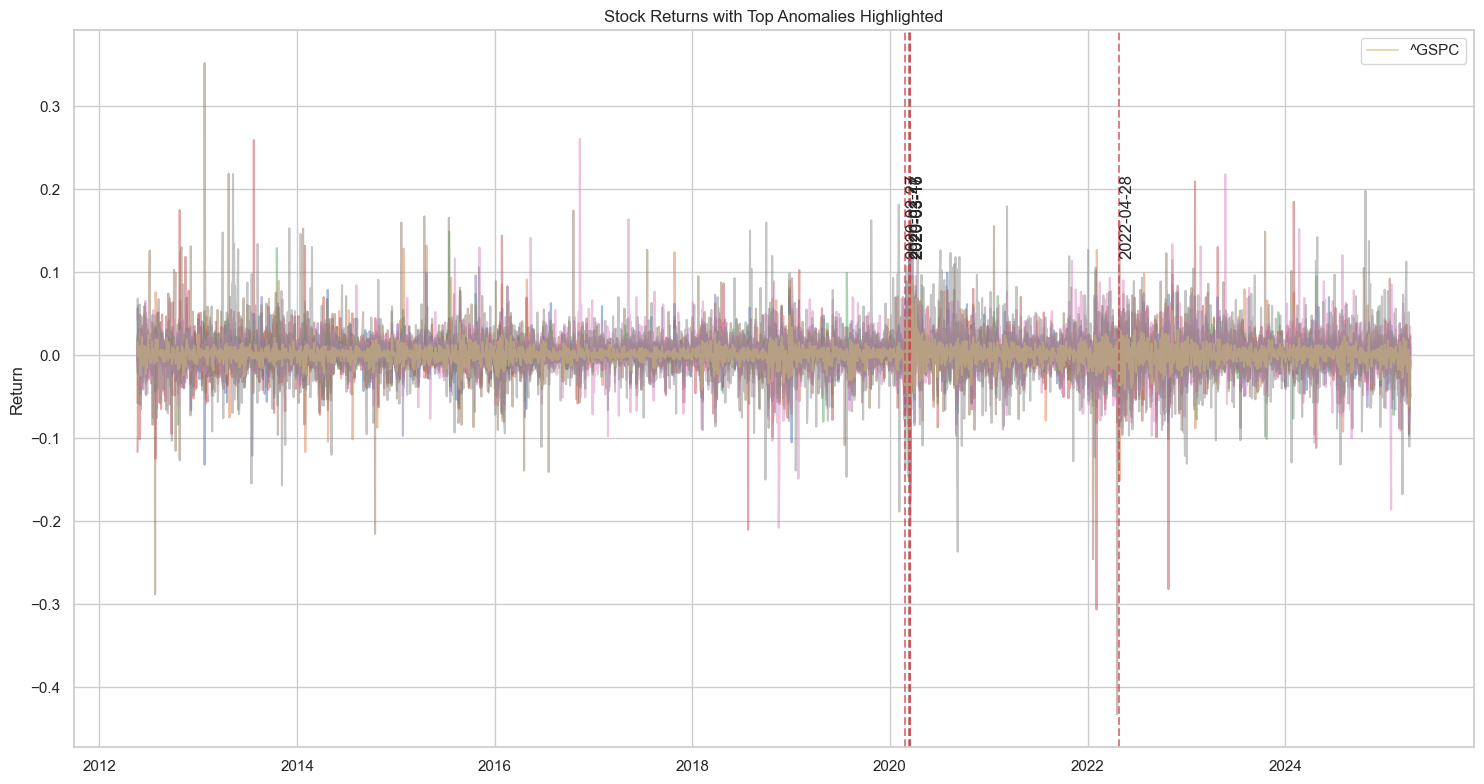

In [63]:
# 1. Simple univariate approach (z-score method)
print("Implementing Z-score based anomaly detection...")
z_scores = (yfinance_returns - yfinance_returns.mean()) / yfinance_returns.std()

# Find max absolute z-score for each day (across all stocks)
max_z_by_day = abs(z_scores).max(axis=1)

# Identify anomalies (days with any z-score > 3)
z_anomalies = max_z_by_day[max_z_by_day > 3]
print(f"Found {len(z_anomalies)} anomalous days using z-score method")

# 2. Isolation Forest on raw returns
print("\nImplementing Isolation Forest anomaly detection...")
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,  # Expect about 1% anomalies
    random_state=42
)
# Fit on raw returns
if_anomaly_scores_raw = iso_forest.fit_predict(yfinance_returns)
if_anomalies_raw = yfinance_returns.index[if_anomaly_scores_raw == -1]
print(f"Found {len(if_anomalies_raw)} anomalous days using Isolation Forest on raw returns")

# 3. Isolation Forest on PCA factors
print("\nImplementing Isolation Forest on PCA factors...")
iso_forest_pca = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)
# Fit on PCA factors
if_anomaly_scores_pca = iso_forest_pca.fit_predict(pca_returns_df)
if_anomalies_pca = pca_returns_df.index[if_anomaly_scores_pca == -1]
print(f"Found {len(if_anomalies_pca)} anomalous days using Isolation Forest on PCA factors")

# 4. Isolation Forest on autoencoder latent features
print("\nImplementing Isolation Forest on autoencoder factors...")
iso_forest_ae = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
)
# Fit on autoencoder factors
if_anomaly_scores_ae = iso_forest_ae.fit_predict(factor_returns_df)
if_anomalies_ae = factor_returns_df.index[if_anomaly_scores_ae == -1]
print(f"Found {len(if_anomalies_ae)} anomalous days using Isolation Forest on autoencoder factors")

# 5. One-Class SVM on raw returns
print("\nImplementing One-Class SVM anomaly detection...")
ocsvm = OneClassSVM(
    kernel='rbf',
    gamma='scale',
    nu=0.01  # Similar to contamination
)
# Fit on raw returns
ocsvm_scores_raw = ocsvm.fit_predict(yfinance_returns)
ocsvm_anomalies_raw = yfinance_returns.index[ocsvm_scores_raw == -1]
print(f"Found {len(ocsvm_anomalies_raw)} anomalous days using One-Class SVM on raw returns")

# Compare results
all_anomalies = pd.DataFrame({
    'Date': pd.Series(list(set(
        z_anomalies.index.tolist() + 
        if_anomalies_raw.tolist() + 
        if_anomalies_pca.tolist() + 
        if_anomalies_ae.tolist() + 
        ocsvm_anomalies_raw.tolist()
    ))).sort_values(),
})

# Mark which methods detected each anomaly
all_anomalies['Z-score'] = all_anomalies['Date'].isin(z_anomalies.index)
all_anomalies['IF-Raw'] = all_anomalies['Date'].isin(if_anomalies_raw)
all_anomalies['IF-PCA'] = all_anomalies['Date'].isin(if_anomalies_pca)
all_anomalies['IF-AE'] = all_anomalies['Date'].isin(if_anomalies_ae)
all_anomalies['OCSVM'] = all_anomalies['Date'].isin(ocsvm_anomalies_raw)

# Count how many methods detected each anomaly
all_anomalies['Detection_Count'] = all_anomalies.iloc[:, 1:].sum(axis=1)

# Sort by number of methods that detected each anomaly
all_anomalies = all_anomalies.sort_values('Detection_Count', ascending=False)

print("\nTop anomalies detected by multiple methods:")
print(all_anomalies.head(10))

# Visualize some top anomalies on the return series
plt.figure(figsize=(15, 8))
for stock in yfinance_returns.columns:
    plt.plot(yfinance_returns.index, yfinance_returns[stock], alpha=0.5, label=stock if stock == '^GSPC' else '')

# Highlight top anomalies
for date in all_anomalies.head(5)['Date']:
    plt.axvline(x=date, color='r', linestyle='--', alpha=0.7)
    plt.text(date, yfinance_returns.loc[date:].max().max(), date.strftime('%Y-%m-%d'), 
             rotation=90, verticalalignment='top')

plt.title('Stock Returns with Top Anomalies Highlighted')
plt.ylabel('Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
# For a specific anomaly date
anomaly_date = '2022-10-27'
print(f"Returns on {anomaly_date}:")
print(yfinance_returns.loc[anomaly_date])

# Compare to average returns
print("\nAverage daily returns:")
print(yfinance_returns.mean())

# Look at market conditions around the anomaly
window_days = 5  # 5 days before and after
start_date = pd.to_datetime(anomaly_date) - pd.Timedelta(days=window_days)
end_date = pd.to_datetime(anomaly_date) + pd.Timedelta(days=window_days)
print(f"\nMarket context ({window_days} days before and after):")
print(yfinance_returns.loc[start_date:end_date])

Returns on 2022-10-27:
Ticker
AAPL    -0.030939
AMZN    -0.041485
GOOG    -0.023691
META    -0.281794
MSFT    -0.019954
NFLX    -0.005642
NVDA     0.021480
TSLA     0.002001
^GSPC   -0.006101
Name: 2022-10-27 00:00:00, dtype: float64

Average daily returns:
Ticker
AAPL     0.000735
AMZN     0.000855
GOOG     0.000706
META     0.000801
MSFT     0.000840
NFLX     0.001379
NVDA     0.001806
TSLA     0.001480
^GSPC    0.000416
dtype: float64

Market context (5 days before and after):
Ticker          AAPL      AMZN      GOOG      META      MSFT      NFLX  \
Date                                                                     
2022-10-24  0.014694  0.004182  0.014576 -0.002233  0.020966 -0.024896   
2022-10-25  0.019153  0.006489  0.018856  0.058318  0.013698  0.029890   
2022-10-26 -0.019822 -0.041824 -0.101313 -0.057548 -0.080295  0.025780   
2022-10-27 -0.030939 -0.041485 -0.023691 -0.281794 -0.019954 -0.005642   
2022-10-28  0.072834 -0.070468  0.042083  0.012783  0.039433 -0.004117 